## plot_ScatDiag_tseries
plot tseries of quantities such as modal NRJ, NRJ flux and scattering term (btrop vs bclin only), for quality-check purpose

N.B.: first time series for beginning was starting at 360, now it starts at 0 (hence the ad-hoc "sufil" variable not to erase the previous figures, which are interesting as well)

see also: plot_NRJ-n-ModScat_any.ip

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid.inset_locator import inset_axes

import numpy as np
import sys, os
from netCDF4 import Dataset#, MFDataset
from datetime import datetime
import scipy.signal as sig
from scipy.ndimage import gaussian_filter
import scipy.interpolate as itp
from PIL import Image, ImageDraw
import json
import pandas as pd

KRYPTON = "/data0/project/vortex/lahaye/"
RUCHBA = KRYPTON+"local_ruchba/"

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
simul = "luckyt"
if simul in ['luckyt']:
    season = "_win"
else:
    season = ""

grid_file = KRYPTON+"/lucky_corgrd.nc"
doms_file = "../NRJ_flux_diag/subdomains_lucky.json"
dirpic = 'pictures/scatdiag_process/'
dosavefig = True

sufil = season#+"_long"
resuf = "_full" if sufil == "_long" else ""

filscat = KRYPTON+'{0}_modemap/{0}_mode_scatdiag{1}.nc'.format(simul,sufil)
filcsv = "./{0}_diagscat{1}.csv".format(simul,sufil)
data_Fa14 = KRYPTON+"Tide_Conv/Falahat_etal_2014_ModalConvM2.nc"

with open(doms_file, "r") as fp:
    mydoms = json.load(fp)
      
# unfold subdomains
doms, nams = [], []
for key,val in mydoms.items():
    if key == "ridges":
        for ido,dom in enumerate(val):
            doms.append(dom)
            nams.append(key.rstrip("s")+str(ido+1))
    else:
        doms.append(val)
        nams.append(key)

# load dataframe
datfra = pd.read_pickle(filcsv.replace("csv","pkl"))
nmod = len(datfra)

rho0 = 1025

nc = Dataset(filscat, "r")
vnams = nc.variables.keys()
nc.close()

print(vnams)
datfra.head()

odict_keys(['time', 'xi_rho', 'eta_rho', 'ocean_time', 'lon_rho', 'lat_rho', 'KE', 'APE', 'TotE', 'KEtser', 'PEtser', 'divf', 'divf_out', 'divf_islands', 'divf_seamounts', 'divf_ridge1', 'divf_ridge2', 'divf_ridge3', 'divf_ridge4', 'divf_full', 'Cmn', 'Cmn_tser', 'Cbcl', 'DissTot', 'DissRes'])


field           Etot                                                          \
domain          full       islands     seamounts        ridge1        ridge2   
0       1.442587e+10  1.145510e+11  5.278718e+09  1.417061e+09  9.433232e+08   
1       2.893475e+09  5.319236e+10  2.386734e+07  6.800228e+06  7.828356e+06   
2       7.091442e+09  1.280902e+11  1.511272e+08  3.866645e+07  3.890036e+07   
3       1.004073e+10  1.790545e+11  3.048533e+08  7.305981e+07  6.016299e+07   
4       1.279747e+10  2.261676e+11  3.966248e+08  1.036350e+08  6.817395e+07   

field                                     KE                        ...     \
domain        ridge3        ridge4      full   islands seamounts    ...      
0       4.581669e+07  4.963424e+06  0.766835  0.969360  1.412875    ...      
1       1.093738e+06  3.387356e+04  0.396348  0.719609  1.002523    ...      
2       3.354125e+06  1.648815e+05  0.329614  0.745093  0.843963    ...      
3       4.904336e+06  2.940036e+05  0.234296  0.495023  0.508764    ...      
4       5.917084e+06  4.642783e+05  0.174200  0.320984  0.341900    ...      

field   Diss_tot                                                Cmn  Diss_res  \
domain    ridge1                                             ridge2    ridge2   
0      -0.003093  [0.00343337181282, 0.00242019975643, 0.0011964... -0.004271   
1       0.001389  [0.00174667134219, 0.000747477649628, 0.000506...  0.000737   
2       0.001160  [0.0010120147605, 0.00048029936546, 0.00013707...  0.001739   
3       0.000923  [0.000896162767124, 0.000335920022663, 0.00013...  0.001261   
4       0.000703  [0.000431907095086, 0.000122073088749, 0.00012...  0.001651   

field   Diss_tot                                                Cmn  Diss_res  \
domain    ridge2                                             ridge3    ridge3   
0       0.005081  [0.00548786211916, 0.00249268719964, 0.0012173... -0.001219   
1       0.004775  [0.00213869772638, 0.000879502354571, 0.000199...  0.001278   
2       0.002074  [0.00151982839167, 0.000693507062928, 0.000198...  0.001615   
3       0.001097  [0.00102072331477, 0.000363718611893, 0.000150...  0.001914   
4       0.000579  [0.000516753455349, 0.000186893135663, 7.05501...  0.001881   

field   Diss_tot                                                Cmn  Diss_res  \
domain    ridge3                                             ridge4    ridge4   
0       0.010144  [0.000996107591139, 0.0013273960097, 0.0010827... -0.001698   
1       0.005069  [0.000109892517234, 0.000184032895989, 0.00014...  0.000457   
2       0.002339  [0.00023025443977, 0.000199757341497, 9.874502...  0.000413   
3       0.001241  [0.000122849491657, 0.000132020105312, 8.69807...  0.000754   
4       0.000825  [3.01872811782e-05, 9.80363582225e-05, 8.53279...  0.000884   

field   Diss_tot  
domain    ridge4  
0       0.004287  
1       0.001149  
2       0.001013  
3       0.000794  
4       0.000706  

[5 rows x 50 columns]

In [3]:
nc = Dataset(filscat, "r")
times = nc.variables['ocean_time'][:]
KE = nc.variables['KEtser'][:]
PE = nc.variables['PEtser'][:]
if simul in ['luckyt']:
    PE *= np.nan
    print("warning: nanned PE")
nc.close()
# correct time if needed
if simul=="luckyt" and season=="_sum" and (np.gradient(times)!=np.diff(times).mean()).any():
    indt = (np.gradient(times)!=np.diff(times).mean())
    dint = np.arange(len(times))
    times[indt] = itp.interp1d(dint[~indt], times[~indt], kind="linear")(dint[indt])
KE.shape

(241, 10)

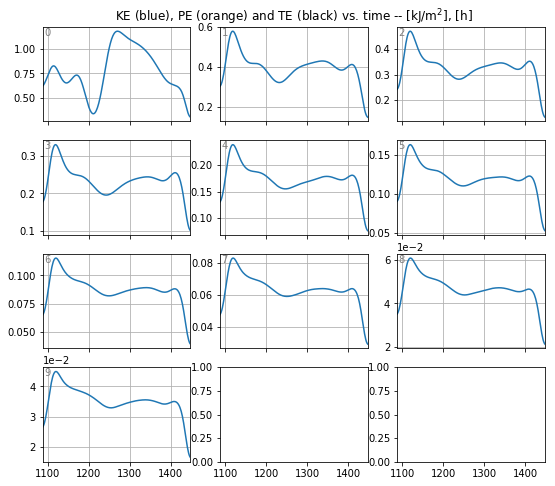

In [4]:
### plot evolution of modal energy averaged over the entire domain
nsbpt = 3

fig, axs = plt.subplots((nmod+nsbpt-1)//nsbpt, nsbpt, sharex=True, figsize=(nsbpt*3, 2*((nmod+nsbpt-1)//nsbpt)))
for ia,ax in enumerate(axs.ravel()):
    if ia>nmod-1:
        break
    ax.plot(times, KE[:,ia], times, PE[:,ia], times, KE[:,ia]+PE[:,ia], "k")
    ax.grid(True)
    ax.text(.01, .99, str(ia), va="top", ha="left", transform=ax.transAxes, color="grey")
    ax.ticklabel_format(style='sci',scilimits=(-2,3), axis="y")
    ax.set_xlim([times[0],times[-1]])
axs[0,1].set_title(r'KE (blue), PE (orange) and TE (black) vs. time -- [kJ/m$^2$], [h]', ha="center")

if dosavefig:
    fig.savefig(dirpic+simul+"_modalNRJevol{}.pdf".format(sufil+resuf), magnification="auto", bbox_inches="tight")

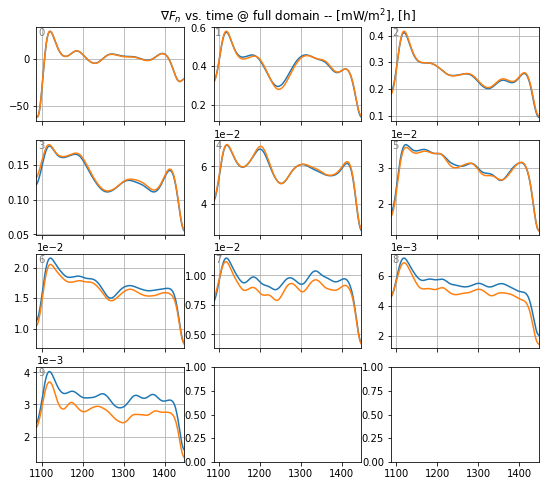

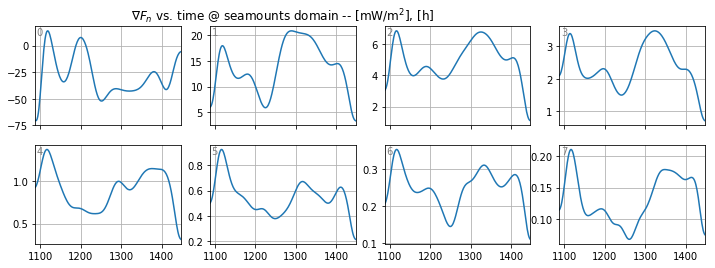

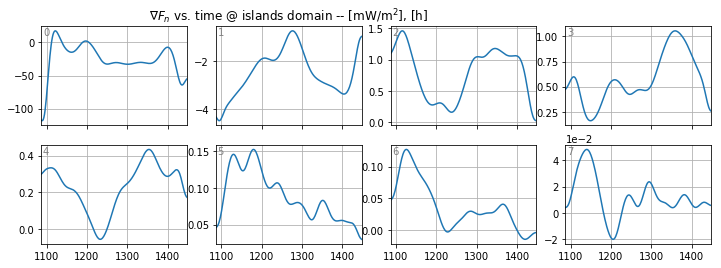

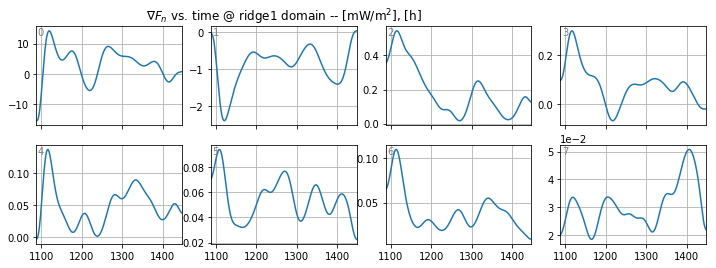

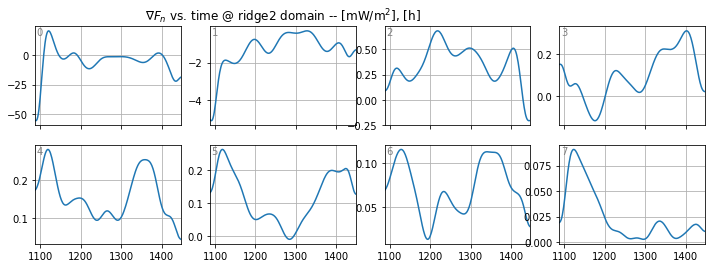

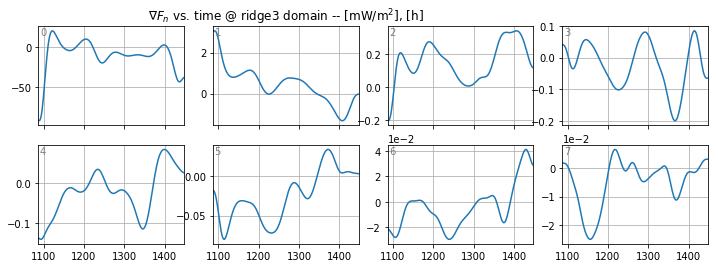

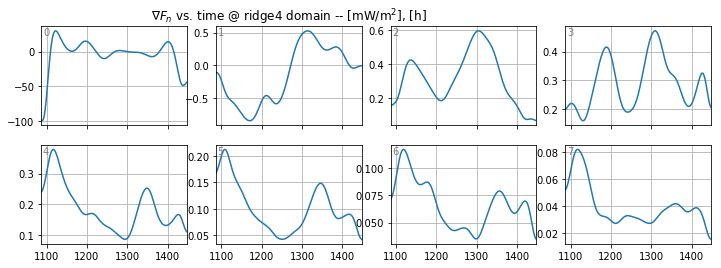

In [5]:
# plot modal NRJ flux divergence time series
nc = Dataset(filscat, "r")
divf = nc.variables['divf_out'][:]*1e3
prov = nc.variables['divf_full'][:]*1e3
nc.close()

fig, axs = plt.subplots((nmod+nsbpt-1)//nsbpt, nsbpt, sharex=True, figsize=(nsbpt*3, 2*((nmod+nsbpt-1)//nsbpt)))
for ia,ax in enumerate(axs.ravel()):
    if ia>nmod-1: break
    ax.plot(times, divf[:,ia], times, prov[:,ia])
    ax.grid(True)
    ax.text(.01, .99, str(ia), va="top", ha="left", transform=ax.transAxes, color="grey")
    ax.ticklabel_format(style='sci',scilimits=(-2,3), axis="y")
    ax.set_xlim([times[0],times[-1]])
axs[0,1].set_title(r'$\nabla F_n$ vs. time @ full domain -- [mW/m$^2$], [h]')

if dosavefig:
    fig.savefig(dirpic+simul+"_modalFluxEvol_full{}.pdf".format(sufil), magnification="auto", bbox_inches="tight")
    
for dom in ["seamounts","islands","ridge1","ridge2","ridge3","ridge4"]:
    nc = Dataset(filscat, "r")
    divf = nc.variables['divf_{}'.format(dom)][:]*1e3
    nc.close()

    fig, axs = plt.subplots(nmod//4, 4, sharex=True, figsize=(12, 2*(nmod//4)))
    for ia,ax in enumerate(axs.ravel()):
        if ia>nmod-1: break
        ax.plot(times, divf[:,ia])
        ax.grid(True)
        ax.text(.01, .99, str(ia), va="top", ha="left", transform=ax.transAxes, color="grey")
        ax.ticklabel_format(style='sci',scilimits=(-2,3), axis="y")
        ax.set_xlim([times[0],times[-1]])
    axs[0,1].set_title(r'$\nabla F_n$ vs. time @ '+dom+' domain -- [mW/m$^2$], [h]')
    
    if dosavefig:
        fig.savefig(dirpic+simul+"_modalFluxEvol_{}.pdf".format(dom+sufil+resuf), magnification="auto", bbox_inches="tight")

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/numpy/ma/core.py:1046: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:5: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  """


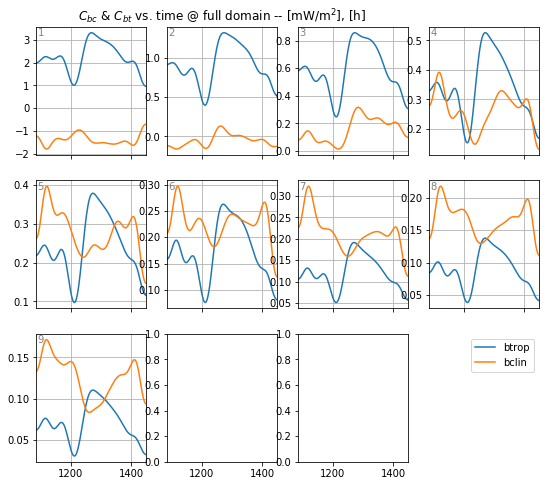

In [6]:
### plot conversion terms time series. Group by Cbtrop and Cbclin
nc = Dataset(filscat, "r")
cmn = nc.variables["Cmn_tser"][:]*1e3
nc.close()
cmn[cmn.mask] = 0

cbtrop = cmn[0,1:]
cbclin = cmn[1:,1:,:].sum(axis=0) - cmn[1:,2:,:].sum(axis=1)

fig, axs = plt.subplots(nsbpt, (nmod+nsbpt-1)//nsbpt, figsize=(nsbpt*3, 2*((nmod+nsbpt-1)//nsbpt)), sharex=True)
for ia,ax in enumerate(axs.ravel()[:-1]):
    if ia+1>nmod-1: break
    hpl = ax.plot(times, cbtrop[ia,:], times, cbclin[ia,:])
    ax.grid(True)
    ax.text(.01, .99, str(ia+1), va="top", ha="left", transform=ax.transAxes, color="grey")
    ax.ticklabel_format(style='sci',scilimits=(-2,3), axis="y")
    ax.set_xlim([times[0],times[-1]])
axs[0,1].set_title(r'$C_{bc}$ & $C_{bt}$ vs. time @ full domain -- [mW/m$^2$], [h]')

axs[-1,-1].legend(hpl,['btrop', 'bclin'])
axs[-1,-1].axis('off')

if dosavefig:
    fig.savefig(dirpic+simul+"_BtclConvEvol_full{}.pdf".format(sufil+resuf), magnification="auto", bbox_inches="tight")

In [78]:
cmn[:,:,0].data

array([[  0.00000000e+00,   2.28484201e+00,   1.12644267e+00,
          6.50898993e-01,   4.17608738e-01,   2.80651271e-01,
          2.05759913e-01,   1.48273423e-01,   1.11982286e-01,
          8.54296759e-02,   6.81050643e-02,   5.73199913e-02,
          4.73595113e-02,   3.88258845e-02,   3.38267311e-02,
          2.83240788e-02,   2.44024377e-02,   2.20797453e-02,
          1.89855359e-02,   1.73450839e-02],
       [  0.00000000e+00,   0.00000000e+00,   4.70288515e-01,
          2.47096822e-01,   1.57082722e-01,   9.68386084e-02,
          6.76920339e-02,   4.42860052e-02,   3.80478650e-02,
          2.88936589e-02,   2.08904799e-02,   1.71951912e-02,
          1.33654559e-02,   1.03079034e-02,   9.19438247e-03,
          7.38719897e-03,   6.71773357e-03,   5.30515099e-03,
          4.95740818e-03,   4.32828395e-03],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.75530010e-01,   1.09815165e-01,   1.06167629e-01,
          5.50622828e-02,   5.01575992e-02

In [49]:
tab.swapaxes(0,1).shape

(3, 2, 4)